# Importation des bibliotheques

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
from timm import create_model
from torchsummary import summary
from sklearn.metrics import classification_report
import torch.nn.functional as F


# Verification du GPU

In [3]:
print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun")


GPU disponible : True
Nom du GPU : Tesla T4


# Chargement et Analyse des donnees

In [4]:
# Chemin du dossier principal
base_path = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset"

# Lister les sous-dossiers (classes)
classes = os.listdir(base_path)
print("Classes disponibles :", classes)

Classes disponibles : ['README.md', 'organized_plums_data_new.csv', 'african_plums']


In [5]:
# Chemin vers le dossier african_plums
plums_path = os.path.join(base_path, "african_plums")

# Vérification que le chemin existe
if not os.path.exists(plums_path):
    print("Erreur : Le dossier african_plums n'existe pas à l'emplacement spécifié.")
    print("Contenu du dossier african_plums_dataset :")
    print(os.listdir(base_path))
else:
    print("Dossier african_plums trouvé avec succès !")

Dossier african_plums trouvé avec succès !


In [6]:
if os.path.exists(plums_path):
    # Lister tous les sous-dossiers (classes)
    classes = [d for d in os.listdir(plums_path) 
              if os.path.isdir(os.path.join(plums_path, d))]
    
    print("\nNombre d'images par classe :")
    print("----------------------------")
    
    for class_name in classes:
        class_path = os.path.join(plums_path, class_name)
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        print(f"{class_name}: {num_images} images")


Nombre d'images par classe :
----------------------------
unripe: 826 images
cracked: 162 images
rotten: 720 images
spotted: 759 images
bruised: 319 images
unaffected: 1721 images


In [9]:
if os.path.exists(plums_path):
    # Préparer les données pour un DataFrame
    data = []
    
    for class_name in os.listdir(plums_path):
        class_path = os.path.join(plums_path, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            data.append({
                "Classe": class_name,
                "Nombre d'images": len(images),
                "Exemple de fichier": images[0] if images else "Aucune"
            })
    
    # Créer et afficher le DataFrame
    df = pd.DataFrame(data)
    print(df)

# Statistiques supplémentaires
    print("\nTotal d'images:", df["Nombre d'images"].sum())

       Classe  Nombre d'images       Exemple de fichier
0      unripe              826      unripe_plum_644.png
1     cracked              162      cracked_plum_42.png
2      rotten              720      rotten_plum_584.png
3     spotted              759     spotted_plum_346.png
4     bruised              319     bruised_plum_144.png
5  unaffected             1721  unaffected_plum_970.png

Total d'images: 4507


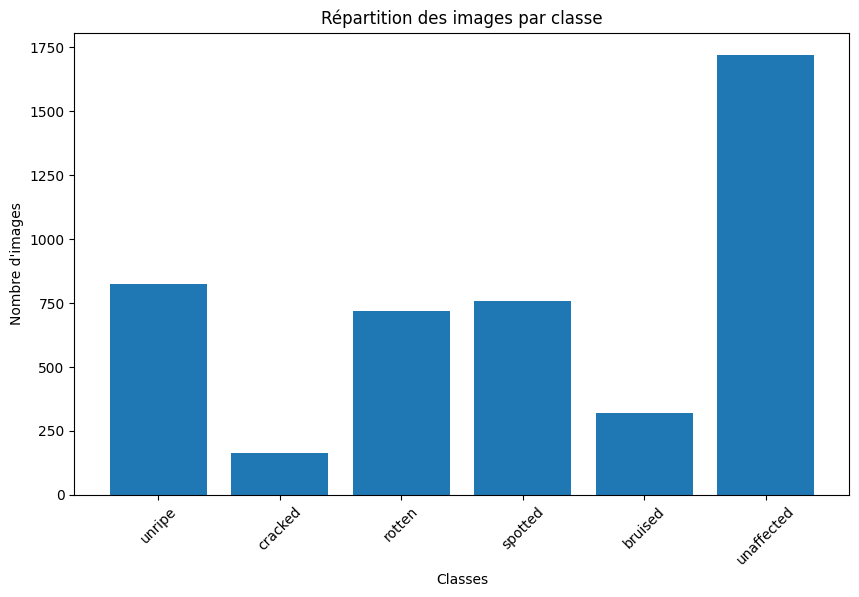

In [11]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(df["Classe"], df["Nombre d'images"])
    plt.title("Répartition des images par classe")
    plt.xlabel("Classes")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.show()

# Decoupage Train/Test

In [12]:
# Chemins
base_path = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums"
output_path = "/kaggle/working/split_data"  # Kaggle permet d'écrire seulement dans /kaggle/working

# Créer les dossiers de sortie
os.makedirs(f"{output_path}/train", exist_ok=True)
os.makedirs(f"{output_path}/test", exist_ok=True)

# Parcourir chaque classe
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    
    # Vérifier que c'est bien un dossier
    if not os.path.isdir(class_path):
        continue
    
    # Lister toutes les images
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Séparation 90/10 avec stratification
    train_files, test_files = train_test_split(
        images,
        test_size=0.1,
        random_state=42  # Pour la reproductibilité
    )
    
    # Créer les sous-dossiers de classe
    os.makedirs(f"{output_path}/train/{class_name}", exist_ok=True)
    os.makedirs(f"{output_path}/test/{class_name}", exist_ok=True)
    
    # Copier les fichiers d'entraînement
    for file in train_files:
        src = os.path.join(class_path, file)
        dst = f"{output_path}/train/{class_name}/{file}"
        shutil.copyfile(src, dst)
    
    # Copier les fichiers de test
    for file in test_files:
        src = os.path.join(class_path, file)
        dst = f"{output_path}/test/{class_name}/{file}"
        shutil.copyfile(src, dst)

print("Division terminée !")
print(f"Train: {len(os.listdir(f'{output_path}/train/{class_name}'))} images par classe")
print(f"Test: {len(os.listdir(f'{output_path}/test/{class_name}'))} images par classe")

Division terminée !
Train: 1548 images par classe
Test: 173 images par classe


In [13]:
data = []
for class_name in os.listdir(base_path):
    train_count = len(os.listdir(f"{output_path}/train/{class_name}"))
    test_count = len(os.listdir(f"{output_path}/test/{class_name}"))
    data.append({
        'Classe': class_name,
        'Train': train_count,
        'Test': test_count,
        '% Test': f"{test_count/(train_count+test_count):.1%}"
    })

pd.DataFrame(data)

,Classe,Train,Test,% Test
0,unripe,743,83,10.0%
1,cracked,145,17,10.5%
2,rotten,648,72,10.0%
3,spotted,683,76,10.0%
4,bruised,287,32,10.0%
5,unaffected,1548,173,10.1%


# Augmentation des donnees

In [19]:
!ls /kaggle/input/african-plums-quality-and-defect-assessment-data
!ls /kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset
!ls /kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums


african_plums_dataset
african_plums  organized_plums_data_new.csv  README.md
bruised  cracked  rotten  spotted  unaffected  unripe


In [20]:
TRAIN_DIR = "/kaggle/working/split_data/train"
TEST_DIR = "/kaggle/working/split_data/test"


In [21]:
!ls "$TRAIN_DIR"
!ls "$TEST_DIR"

bruised  cracked  rotten  spotted  unaffected  unripe
bruised  cracked  rotten  spotted  unaffected  unripe


# Transformations avec augmentation ciblée 


In [48]:
# --- Transformations avec augmentation ciblée ---
IMG_SIZE = 224

class EnhancedTransform:
    def __init__(self):
        # Transformations avec augmentations
        self.enhanced_transform = transforms.Compose([
            transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.RandomRotation(30)
        ])

        # Transformation de base (resize, tensor, normalisation)
        self.base_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        # Applique l'augmentation renforcée avec probabilité 50%
        x = self.enhanced_transform(x) if torch.rand(1) < 0.5 else x
        # Appliquer la transformation de base après l'augmentation
        return self.base_transform(x)


In [49]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=EnhancedTransform())
test_dataset = datasets.ImageFolder(TEST_DIR, transform=EnhancedTransform())


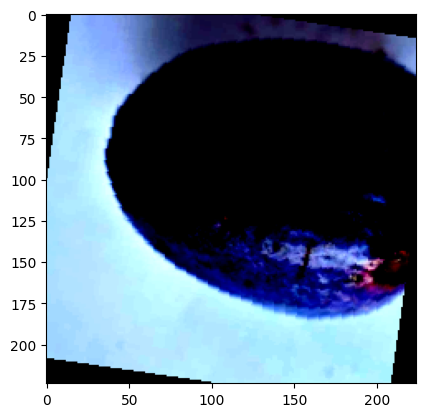

In [50]:
# Vérifier une image du train_dataset
sample_image, _ = train_dataset[0]

# Convertir en image pour affichage
sample_image = sample_image.permute(1, 2, 0)  # Revertir les dimensions (C, H, W) -> (H, W, C)

# Affichage
plt.imshow(sample_image)
plt.show()


# # Comptage des classes et calcul des poids et reequilibrage


In [45]:
class_counts = Counter(train_dataset.targets)
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples/(len(class_counts)*count) for cls, count in class_counts.items()}
samples_weights = [class_weights[cls] for cls in train_dataset.targets]


In [51]:
BATCH_SIZE = 32
# Sampler pour rééquilibrage
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



# Modèle avec Fine-Tuning Sélectif

In [28]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 6)
model = model.to(DEVICE)

# Gel des couches basses, optimisation et regularisation

In [31]:
for name, param in model.named_parameters():
    if "head" not in name and "blocks.11" not in name:  # Dégèle la tête et les derniers blocs
        param.requires_grad = False

# --- Loss et Optimiseur ---

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Applique la fonction softmax à inputs pour obtenir des probabilités
        inputs = F.softmax(inputs, dim=1)
        
        # Crée un vecteur avec les probabilités de la classe cible
        targets = F.one_hot(targets, num_classes=inputs.size(1)).float()

        # Calcule la perte de Focal Loss
        cross_entropy_loss = -targets * torch.log(inputs)
        loss = self.alpha * (1 - inputs) ** self.gamma * cross_entropy_loss

        # Agrège les pertes selon le type de réduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [32]:
# Poids inversement proportionnels aux fréquences de classe
alpha = torch.tensor([1/class_counts[i] for i in range(6)]).float().to(DEVICE)
alpha = alpha / alpha.sum() * 6  # Normalisation
criterion = FocalLoss(alpha=alpha, gamma=2.0)

optimizer = torch.optim.AdamW([
    {'params': model.head.parameters(), 'lr': 1e-3},
    {'params': model.blocks[-4:].parameters(), 'lr': 1e-4}
], lr=1e-5)

#  Entraînement avec Early Stopping

In [53]:
best_f1 = 0
patience = 5
epochs_no_improve = 0
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):
    model.train()  # Passer en mode entraînement
    start_time = time.time()
    
    # Entraînement sur le train_loader
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Validation sur le jeu de validation/test
    model.eval()  # Passer en mode évaluation (désactive Dropout, BatchNorm)
    all_preds, all_labels = [], []
    
    with torch.no_grad():  # Désactive le calcul des gradients
        for images, labels in test_loader:  # Utilise test_loader pour la validation
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcul du F1-score pondéré pour la validation
    report = classification_report(all_labels, all_preds, output_dict=True)
    current_f1 = report['weighted avg']['f1-score']
    
    # Affichage des résultats
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {loss.item():.4f} | Validation F1: {current_f1:.4f} | Time: {time.time()-start_time:.2f}s")
    
    # Early stopping (si le F1-score sur la validation ne s'améliore pas)
    if current_f1 > best_f1:
        best_f1 = current_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # Sauvegarde le meilleur modèle
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}!")
            break


Epoch 1/20 | Loss: 0.0311 | Validation F1: 0.6227 | Time: 70.45s
Epoch 2/20 | Loss: 0.0320 | Validation F1: 0.6251 | Time: 68.99s
Epoch 3/20 | Loss: 0.0279 | Validation F1: 0.6090 | Time: 69.39s
Epoch 4/20 | Loss: 0.0402 | Validation F1: 0.6569 | Time: 68.73s
Epoch 5/20 | Loss: 0.0584 | Validation F1: 0.6126 | Time: 68.67s
Epoch 6/20 | Loss: 0.0165 | Validation F1: 0.6523 | Time: 68.95s
Epoch 7/20 | Loss: 0.0300 | Validation F1: 0.6613 | Time: 69.42s
Epoch 8/20 | Loss: 0.0283 | Validation F1: 0.5831 | Time: 68.95s
Epoch 9/20 | Loss: 0.0222 | Validation F1: 0.6620 | Time: 68.61s
Epoch 10/20 | Loss: 0.0128 | Validation F1: 0.6495 | Time: 68.52s
Epoch 11/20 | Loss: 0.0171 | Validation F1: 0.6063 | Time: 68.52s
Epoch 12/20 | Loss: 0.0670 | Validation F1: 0.6632 | Time: 68.95s
Epoch 13/20 | Loss: 0.0123 | Validation F1: 0.6048 | Time: 68.94s
Epoch 14/20 | Loss: 0.0272 | Validation F1: 0.6410 | Time: 69.02s
Epoch 15/20 | Loss: 0.0353 | Validation F1: 0.6002 | Time: 68.90s
Epoch 16/20 | Loss:

NameError: name 'train_losses' is not defined

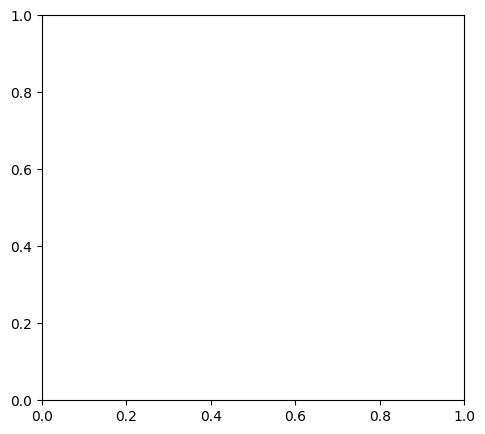

In [54]:
# Afficher les courbes de perte et de F1-score **après l'entraînement**
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label="Train Loss", color='b')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label="Validation Loss", color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Courbe de F1-score
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), train_f1_scores, label="Train F1", color='b')
plt.plot(range(1, NUM_EPOCHS+1), val_f1_scores, label="Validation F1", color='r')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('Train vs Validation F1-score')
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()


In [55]:
# --- Chargement du meilleur modèle ---
model.load_state_dict(torch.load("best_model.pth"))

# --- Évaluation Finale ---
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Ajustement des seuils pour les classes faibles
thresholds = {
    "bruised": 0.25,  # Plus sensible
    "cracked": 0.3,
    "spotted": 0.35
}

class_names = test_dataset.classes
adjusted_preds = []
for prob in all_probs:
    if prob[0] > thresholds["bruised"]:
        adjusted_preds.append(0)
    elif prob[1] > thresholds["cracked"]:
        adjusted_preds.append(1)
    elif prob[3] > thresholds["spotted"]:
        adjusted_preds.append(3)
    else:
        adjusted_preds.append(np.argmax(prob))

<ipython-input-55-f899e12513fd>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [56]:
# Rapport final
print("\n--- Rapport Final (avec seuils adaptatifs) ---")
print(classification_report(all_labels, adjusted_preds, target_names=class_names))
print("\nMatrice de Confusion:")
print(confusion_matrix(all_labels, adjusted_preds))


--- Rapport Final (avec seuils adaptatifs) ---
              precision    recall  f1-score   support

     bruised       0.25      0.44      0.32        32
     cracked       0.37      0.82      0.51        17
      rotten       0.90      0.65      0.76        72
     spotted       0.36      0.53      0.43        76
  unaffected       0.85      0.61      0.71       173
      unripe       0.78      0.67      0.72        83

    accuracy                           0.61       453
   macro avg       0.59      0.62      0.57       453
weighted avg       0.70      0.61      0.64       453


Matrice de Confusion:
[[ 14   5   2   7   3   1]
 [  1  14   0   1   1   0]
 [ 15   6  47   4   0   0]
 [ 11   2   3  40  11   9]
 [  8  11   0  42 106   6]
 [  7   0   0  16   4  56]]
